# Custom Model Building

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/AI_4_Climate_Bootcamp/blob/main/Week 06 - Advanced TensorFlow/1. Custom Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

So far, we have been using the Sequential model and the `.fit()` function to train our models. However, for more advanced tasks, we may need to use more advanced approaches for building and training our models. 

In this notebook, we will explore building different types of models in TensorFlow:
- Sequential models (which we have already seen)
- Functional models
- Subclassing models

Each of these approaches has its own advantages and disadvantages, and it is important to understand when to use each one. For example, functional models are more flexible and allow for more complex architectures, while subclassing models give us more control over the training process.

We will start by revisiting the Sequential model and then move on to the other approaches. By the end of this notebook, you will have a better understanding of the different ways to build models in TensorFlow and when to use each one.

## Table of Contents <a name="toc"></a>
- [Data Loading & Preprocessing](#data)
- [Custom Model Building](#custom-models)
    - [Sequential Model](#sequential-models)
      - [Normal Output](#normal-output)
      - [Sparse Output](#sparse-output)
      - [Logits Output](#logits-output)
    - [Functional Model](#functional-api)
    - [Subclassing Model](#subclass)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds  # datasets
from tqdm.notebook import tqdm  # progress bar

## Data Loading & Preprocessing <a name="data"></a>
[Back to Top](#toc)

We will revisit the Fashion MNIST dataset that we used in the previous notebook. This time we will load it using `tensorflow_datasets`. This is a library that provides a number of popular datasets and makes it easy to load them into TensorFlow.

In [2]:
dataset, info = tfds.load(
    "fashion_mnist",  # name of the dataset
    as_supervised=True,  # returns (image, label)
    with_info=True,  # returns info about the dataset
)

# display info about the dataset
info

Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-14 18:27:33.827918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 18:27:33.828069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/Users/sniperdw/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      

In [3]:
# from the info we see that there are 2 splits: train and test. We can access them like this:
dataset["train"]  # train split
dataset["test"]  # test split

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
# we can also access classes and thier names
labels_index = info.features["label"].names
labels_index

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

2023-02-14 18:28:18.939821: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 18:28:19.040734: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


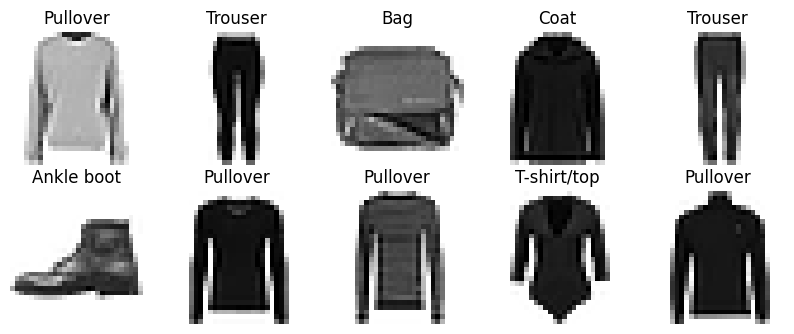

In [6]:
# plot the first 10 images in the training set and their labels
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset["train"].take(10)):
    plt.subplot(5, 5, i + 1)
    image = tf.reshape(image, (28, 28))
    plt.imshow(image, cmap="binary")
    plt.title(labels_index[int(label)])
    plt.axis("off")

In [ ]:
# we will create two functions to preprocess the images and labels


# this will only preprocess the images and labels without one hot encoding
def preprocess(image, label):
    image = tf.reshape(image, (28, 28, 1))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label


# this will preprocess the images and labels and one hot encode the labels
def preprocess_with_one_hot(image, label):
    image, label = preprocess(image, label)
    label = tf.one_hot(label, depth=len(labels_index))
    return image, label

In [ ]:
# we will create a function to prepare the dataset for training
def dataset_prep(dataset, one_hot=True):
    if (
        one_hot
    ):  # if one hot is True, we will use the function that one hot encodes the labels
        dataset = dataset.map(
            preprocess_with_one_hot, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    else:  # otherwise we will use the function that does not one hot encode the labels
        dataset = dataset.map(
            preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

    # shuffle the dataset
    dataset = dataset.shuffle(1000)

    # batch the dataset
    dataset = dataset.batch(32)

    # prefetch the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## Custom Model Building <a name="custom-models"></a>
[Back to Top](#toc)

In this section, we will explore the different ways to build models in TensorFlow. We will start by revisiting the Sequential model and then move on to the other approaches. By the end of this notebook, you will have a better understanding of the different ways to build models in TensorFlow and when to use each one.

### Type 1: Sequential Models <a name="sequential-models"></a>
[Back to Top](#toc)

Sequential models are the simplest type of model in TensorFlow. They are made up of a linear stack of layers, and each layer has exactly one input tensor and one output tensor. The most common type of layer is the `Dense` layer, which is a fully-connected layer.

#### Normal Output <a name="normal-output"></a>
[Back to Top](#toc)

We will start by building a model that outputs a one-hot encoded vector. This is the most common type of output for classification problems. The output will be a vector of length 10, with a 1 in the position of the class and 0s everywhere else. For example, if the model predicts that the image is a shirt, the output will be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`.

In [ ]:
train_dataset = dataset_prep(source_train_dataset)
test_dataset = dataset_prep(source_test_dataset)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, 3, padding="same", activation="relu", input_shape=(28, 28, 1)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

#### Sparse Output <a name="sparse-output"></a>
[Back to Top](#toc)

We will now build a model that outputs a single integer. This is the most common type of output for classification problems. The output will be a single integer, which is the index of the class. For example, if the model predicts that the image is a shirt, the output will be `5`.

In [ ]:
# we will load the dataset again but this time we will not one hot encode the labels
train_dataset = dataset_prep(source_train_dataset, one_hot=False)
test_dataset = dataset_prep(source_test_dataset, one_hot=False)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, 3, padding="same", activation="relu", input_shape=(28, 28, 1)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(
            10, activation="softmax"
        ),  # we will still use 10 neurons in the output layer
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # we will use SparseCategoricalCrossentropy because we are not one hot encoding the labels
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ],  # we will use SparseCategoricalAccuracy because we are not one hot encoding the labels
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

#### Logits Output <a name="logits-output"></a>
[Back to Top](#toc)

We will now build a model that outputs a vector of logits. This is the most common type of output for classification problems. The output will be a vector of length 10, with a real number in each position instead of probabilities. For example, if the model predicts that the image is a shirt, the output will be `[-2.4, -1.2, 1.7, 0.5, 0.3, 1.2, 3.14, -0.2, -2.1, 0.1]`.



In [ ]:
train_dataset = dataset_prep(source_train_dataset)
test_dataset = dataset_prep(source_test_dataset)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, 3, padding="same", activation="relu", input_shape=(28, 28, 1)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=True
    ),  # we will use from_logits=True because we are not using softmax activation in the output layer
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

### Type 2: Functional API <a name="functional-api"></a>
[Back to Top](#toc)

The functional API allows us to build more complex models such as Multi-Input models, Multi-Output models, and directed acyclic graphs. It is also a more flexible and straightforward way to build complex models when compared to the sequential API.

In the functional API, we define the input layer and specify how the inputs flow through the model by defining the forward pass. This allows us to have more control over the architecture of the model and allows us to build more complex models that cannot be built using the Sequential API.

In [ ]:
train_dataset = dataset_prep(source_train_dataset)
test_dataset = dataset_prep(source_test_dataset)

# building the model starts by creating the input layer
inputs = tf.keras.Input(shape=(28, 28, 1))

# we then pass the input through the layers in the desired order
x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

# and finally we create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

# the model is then created by passing the inputs and outputs to the Model class
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# the rest of code is the same as before
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

### Type 3: Subclass API <a name="subclass"></a>
[Back to Top](#toc)

The Subclass API in Keras allows developers to create custom models by subclassing `tf.keras.Model` and defining their own forward pass. This is useful when you need more control over the architecture of your model, such as when creating complex models with multiple branches or when creating models with non-standard layers that are not available in Keras.

To use the Subclass API, you need to define your own custom class that extends `tf.keras.Model`, and override the following methods:

-`__init__`: where you will initialize the layers of your model.
-`call`: where you will define the forward pass of your model.

Using the Subclass API is a more advanced approach to building models in Keras and requires a deeper understanding of the framework. However, it gives you the flexibility to define complex models that cannot be achieved using the Sequential or Functional API.



In [ ]:
train_dataset = dataset_prep(source_train_dataset)
test_dataset = dataset_prep(source_test_dataset)


class FMNISTModel(tf.keras.Model):
    # we will define the layers in the __init__ method
    def __init__(self):
        super(
            FMNISTModel, self
        ).__init__()  # we need to call the super class's __init__ method to initialize the parent class

        # now we define the layers and store them as class attributes for later use
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation="relu")
        self.dense2 = tf.keras.layers.Dense(10, activation="softmax")

    # we will define the forward pass in the call method
    def call(self, inputs):
        # we will pass the inputs through the layers in the desired order
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)

        # and finally we return the output of the last layer
        return self.dense2(x)


# to instantiate the model we just need to call the class
model = FMNISTModel()

# the rest of code is the same as before
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 0.4014 - categorical_accuracy: 0.8549 - val_loss: 0.3489 - val_categorical_accuracy: 0.8757
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2605 - categorical_accuracy: 0.9049 - val_loss: 0.2820 - val_categorical_accuracy: 0.8979
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2166 - categorical_accuracy: 0.9200 - val_loss: 0.2490 - val_categorical_accuracy: 0.9090
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1832 - categorical_accuracy: 0.9321 - val_loss: 0.2397 - val_categorical_accuracy: 0.9136
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1541 - categorical_accuracy: 0.9434 - val_loss: 0.2414 - val_categorical_accuracy: 0.9155
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1293 - categorical_accuracy: 0.9518 - val_loss: 0.2637 - val_categorical_acc